# Analyzing (frataxin) molecular dynamics trajectories

### 2/5/2021

Additional material:

http://mscbio2025.csb.pitt.edu/notes/mdanalysis.slides.html

http://mscbio2025.csb.pitt.edu/notes/md2.slides.html

# The Big Question:
## How do mutations change the dynamics of the protein?

# MDAnalysis

Python package for reading and analyzing molecular dynamics trajectories.

https://www.mdanalysis.org/

A simulation ("universe") is defined by its topology file (prmtop) and trajectory (dcd or nc)

In [1]:
import MDAnalysis

traj1 = MDAnalysis.Universe('wt/wt_amber.prmtop', 'wt/wt_amber_1.dcd')
traj2 = MDAnalysis.Universe('wt/wt_amber.prmtop', 'wt/wt_amber_2.dcd')
traj3 = MDAnalysis.Universe('wt/wt_amber.prmtop', 'wt/wt_amber_3.dcd')
traj = MDAnalysis.Universe('wt/wt_amber.prmtop', ['wt/wt_amber_1.dcd','wt/wt_amber_2.dcd','wt/wt_amber_3.dcd'])

ModuleNotFoundError: No module named 'MDAnalysis'

I have downsampled the original simulation and aligned the backbone.

`cpptraj` script:
```
parm wt_amber.prmtop
trajin wt_amber_1_md3.nc 1 last 10
autoimage
rms first @CA
trajout wt_amber_1.dcd dcd nobox
```

In [3]:
traj1

<Universe with 22827 atoms>

In [4]:
traj1.trajectory

<DCDReader wt/wt_amber_1.dcd with 1000 frames of 22827 atoms>

# RMSD

Root mean squared deviation (RMSD)
$$\sqrt{\frac{\sum_i^n(x_i^a-x_i^b)^2+(y_i^a-y_i^b)^2+(z_i^a-z_i^b)^2}{n}}$$

In [7]:
from MDAnalysis.analysis.rms import rmsd #pull in rmsd function
prot = traj.select_atoms("protein") #only care about protein, not water/ions
refcoord = prot.positions #save initial coordinates
rmsds = [rmsd(refcoord,prot.positions) for ts in traj.trajectory]  #coordinates implicitly update as you iterate

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

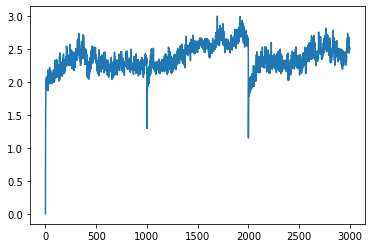

In [10]:
plt.plot(rmsds)

What does this tell us?

In [11]:
traj.trajectory[-1] #set to last frame
lastcoord = prot.positions
lastrmsds = [rmsd(lastcoord,prot.positions) for ts in traj.trajectory]

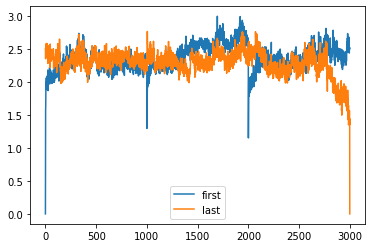

In [18]:
plt.plot(rmsds,label='first')
plt.plot(lastrmsds,label='last')
plt.legend();

In [37]:
from MDAnalysis.analysis.align import AlignTraj
#align to loop

align = AlignTraj(traj, traj, select='backbone',filename='aligned.dcd')
align.run()                                

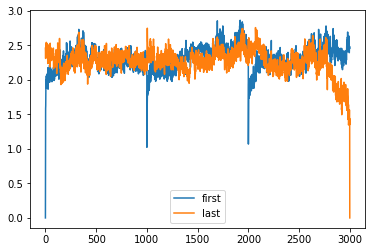

In [39]:
traj = MDAnalysis.Universe('wt/wt_amber.prmtop','aligned.dcd')
prot = traj.select_atoms("protein") #only care about protein, not water/ions
refcoord = prot.positions #save initial coordinates
rmsds = [rmsd(refcoord,prot.positions) for ts in traj.trajectory] 
traj.trajectory[-1] #set to last frame
lastcoord = prot.positions
lastrmsds = [rmsd(lastcoord,prot.positions) for ts in traj.trajectory]

plt.plot(rmsds,label='first')
plt.plot(lastrmsds,label='last')
plt.legend();

In [40]:
#loading all the coordinates into memory takes about 1GB
coords = [prot.positions for ts in traj.trajectory]

In [ ]:
import multiprocessing
n = len(coords)
def row_rmsds(i):
    return  [rmsd(coords[i],coords[j]) for j in range(n)]
pool = multiprocessing.Pool()
rmat = pool.map(row_rmsds,range(n))

Making the above twice as fast is left as an exercise for the reader.

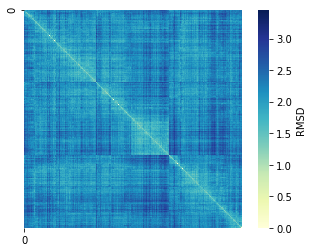

In [42]:
import seaborn as sns
rmat = np.array(rmat)
sns.heatmap(rmat,square=True,xticklabels=n,yticklabels=n,cmap='YlGnBu',cbar_kws={'label':'RMSD'},vmin=0);

What does this tell us?

# PCA

<img width="400px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/1280px-GaussianScatterPCA.svg.png">

In [43]:
from MDAnalysis.analysis import pca
pc = pca.PCA(traj, select='backbone').run()

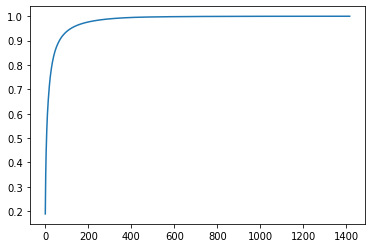

In [50]:
plt.plot(pc.cumulated_variance)

In [55]:
backbone = traj.select_atoms('backbone')
backbone

<AtomGroup with 472 atoms>

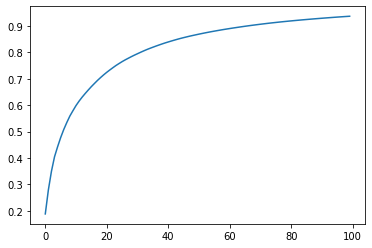

In [54]:
plt.plot(pc.cumulated_variance[:100])

In [56]:
transformed = pc.transform(backbone, n_components=10)

In [57]:
traj.trajectory

<DCDReader aligned.dcd with 3000 frames of 22827 atoms>

In [59]:
import pandas as pd
df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(10)])
df['sim'] = df.index//1000
df['Time (ps)'] = df.index * u.trajectory.dt
df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,sim,Time (ps)
0,-2.901878,-1.381989,-15.505499,0.713734,1.151404,3.032116,0.519691,0.298446,2.686070,-0.059783,0,0.000000
1,-2.390118,-4.101201,-13.187061,3.305353,0.362939,-1.099120,1.617562,-2.974982,4.230857,-4.545147,0,0.000049
2,-3.225154,-3.136984,-12.841184,2.945615,0.070979,-4.939210,1.841554,-1.970189,-1.335142,-1.088082,0,0.000098
3,-9.836594,-0.372700,-14.308532,6.051637,1.660262,-1.978671,0.584544,-1.687415,-2.311352,0.821889,0,0.000147
4,-12.443729,-4.770219,-11.416638,6.836731,0.046444,-7.337171,-1.570999,-3.827739,-2.669364,4.712605,0,0.000196
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,7.721263,5.326934,-4.120338,-9.001223,0.281569,0.095127,-1.617441,-8.948532,-3.191316,-1.071643,2,0.146420
2996,9.301868,4.756724,-1.827657,-5.620303,0.258789,0.510859,-0.734844,-7.921880,-4.532978,2.652904,2,0.146469
2997,5.053161,7.434399,-1.242725,-2.823438,-3.119645,-1.771552,-0.519824,-4.979009,-5.458433,-1.898075,2,0.146518
2998,7.672216,10.353063,0.568196,-5.735955,-1.294599,-0.749878,0.627956,-7.772218,-4.710042,2.179812,2,0.146567


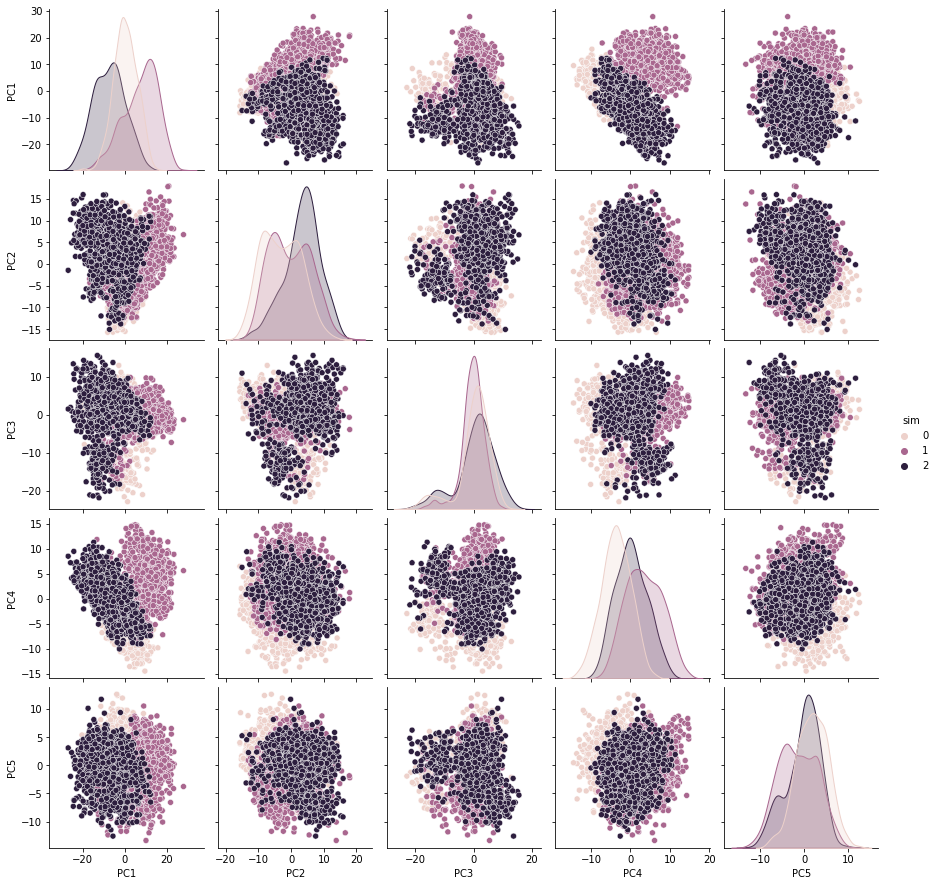

In [76]:
g = sns.pairplot(df,vars=('PC1','PC2','PC3','PC4','PC5'),hue='sim')

# Residue Level Differences

* RMSF (root mean squared fluctuations)
* Contacts
* Solvent accessibility


# Root Mean Squared Fluctuations

$$\rho_i = \sqrt{\left\langle (\mathbf{x}_i - \langle\mathbf{x}_i\rangle)^2 \right\rangle}$$

How much does a residue deviate from its mean coordinates?

In [154]:
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSF

def get_rmsf(t,label=None):
    sel = 'protein and not name H*'
    prot = t.select_atoms(sel)
    average_coordinates = t.trajectory.timeseries(asel=prot).mean(axis=1)
    # make a reference structure (need to reshape into a 1-frame "trajectory")
    reference = MDAnalysis.Merge(prot).load_new(average_coordinates[:, None, :], order="afc")
    aligner = align.AlignTraj(t, reference, select=sel, in_memory=True).run()
    rmsfer = RMSF(prot).run()
    ret = pd.DataFrame(zip(prot.resnums,rmsfer.rmsf),columns=('resid','rmsf'))
    if label != None:
        ret['label'] = label
    return ret

In [155]:
rmsf1 = get_rmsf(traj1,1)
rmsf2 = get_rmsf(traj2,2)
rmsf3 = get_rmsf(traj3,3)
rmsf = pd.concat([rmsf1,rmsf2,rmsf3])

/usr/local/lib/python3.8/dist-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


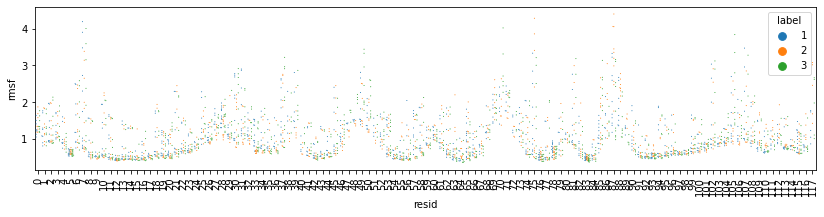

In [168]:
import warnings; warnings.simplefilter('ignore')
fig, ax = plt.subplots(figsize=(14,3))
sns.swarmplot(data=rmsf,x='resid',y='rmsf',hue='label',dodge=True,size=1,ax=ax)
ax.set_xticklabels(ax.get_xticks(), rotation = 90);

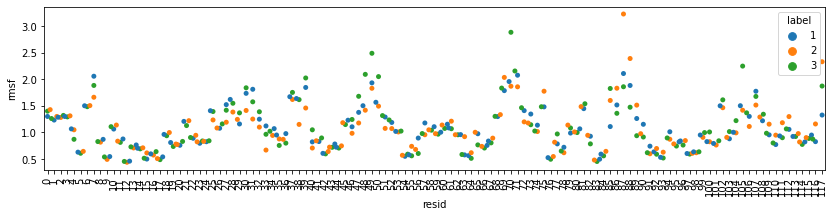

In [169]:
d = rmsf.groupby(['resid','label']).mean().reset_index()
fig, ax = plt.subplots(figsize=(14,3))
sns.swarmplot(data=d,x='resid',y='rmsf',hue='label',ax=ax)
ax.set_xticklabels(ax.get_xticks(), rotation = 90);

## Are differences meaningful?

Given multiple samples from distributions we can compare to the null hypothesis that the two samples have the same mean.

In [171]:
from scipy.stats import ttest_ind
ttest_ind([0.9,1,1.1],[1,1,1])

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [176]:
ttest_ind([0.9,1,1.1],[2,1.5,3])

Ttest_indResult(statistic=-2.623360911485515, pvalue=0.058592469474123776)

Even with only three samples, we can compute statistical significance - but need another distribution to compare against (the mutation simulations).

# Contacts

A contact just means two atoms are within a specified distance of one another.

In [179]:
from MDAnalysis.analysis import distances
protein = t.select_atoms('protein')
self_distances = distances.self_distance_array(protein.positions)

In [184]:
self_distances.shape

(1675365,)

In [234]:
n = len(protein)
sq_dist_arr = np.zeros((n, n))
triu = np.triu_indices_from(sq_dist_arr, k=1)
sq_dist_arr[triu] = self_distances
sq_dist_arr.T[triu] = self_distances

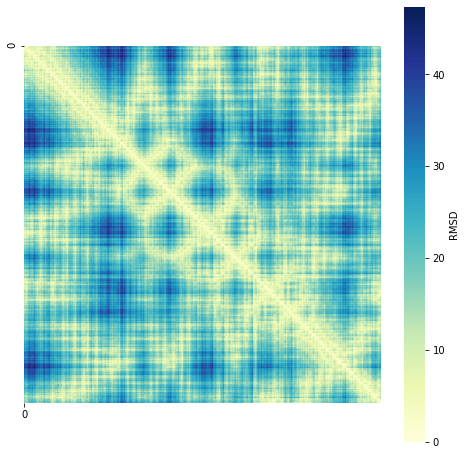

In [235]:
plt.figure(figsize=(8,8))
sns.heatmap(sq_dist_arr,square=True,xticklabels=n,yticklabels=n,cmap='YlGnBu',cbar_kws={'label':'RMSD'},vmin=0);

Given a contact distance of 2A let's count the number of intra-molecular contacts each residue is making.

We are applying a **hard** cutoff.  [Soft cutoffs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/contacts.html#MDAnalysis.analysis.contacts.soft_cut_q) could also be implemented.

In [238]:
cutoff = 2.0
contacts = np.where(sq_dist_arr < cutoff, 1, 0)
df = pd.DataFrame(zip(protein.resids,contacts.sum(axis=0)),columns=('resid','contacts'))
rescontacts = df.groupby('resid').sum().reset_index()

In [239]:
rescontacts

,resid,contacts
0,1,83
1,2,42
2,3,53
3,4,54
4,5,52
...,...,...
113,114,72
114,115,38
115,116,70
116,117,37


In [241]:
def get_rescontacts(protein,cutoff=2):
    '''Given an mdanalysis selection and contact distance cutoff, 
    count the number of internal contacts for each residue.'''
    n = len(protein)
    #calc distances
    self_distances = distances.self_distance_array(protein.positions)    
    #make square array
    sq_dist_arr = np.zeros((n, n))
    triu = np.triu_indices_from(sq_dist_arr, k=1)
    sq_dist_arr[triu] = self_distances
    sq_dist_arr.T[triu] = self_distances    
    #binarize the matrix
    contacts = np.where(sq_dist_arr < cutoff, 1, 0)
    df = pd.DataFrame(zip(protein.resids,contacts.sum(axis=0)),columns=('resid','contacts'))
    rescontacts = df.groupby('resid').sum().reset_index()    
    return rescontacts

Is this counting the number of atoms within cutoff of each residue?

In [242]:
traj1contacts = []
protein = traj1.select_atoms('protein')

for ts in traj1.trajectory:
    rc = get_rescontacts(protein)
    traj1contacts.append(rc.contacts.to_numpy())    
    
traj2contacts = []
protein = traj2.select_atoms('protein')

for ts in traj2.trajectory:
    rc = get_rescontacts(protein)
    traj2contacts.append(rc.contacts.to_numpy())        

In [243]:
traj1contacts = np.array(traj1contacts)
traj2contacts = np.array(traj2contacts)

Parallelizing the above is left as an exercise for the reader.

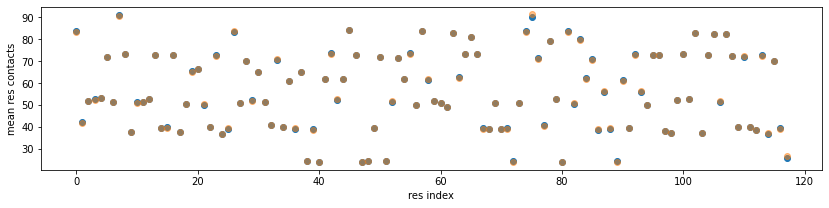

In [294]:
plt.figure(figsize=(14,3))
plt.plot(traj1contacts.mean(axis=0),'o',label='traj1')
plt.plot(traj2contacts.mean(axis=0),'o',label='traj2',alpha=.5)
plt.xlabel('res index')
plt.ylabel('mean res contacts');

In [247]:
traj1contacts[:,0][:10]

array([83, 84, 82, 84, 85, 84, 84, 83, 85, 85])

In [248]:
traj2contacts[:,0][:10]

array([83, 83, 85, 84, 82, 84, 82, 82, 83, 83])

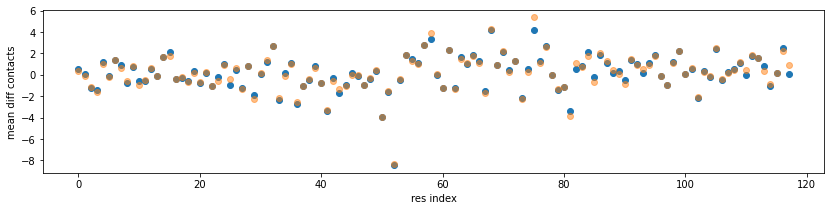

In [295]:
plt.figure(figsize=(14,3))
plt.plot(traj1contacts.mean(axis=0)-traj1contacts[0,:],'o',label='traj1')
plt.plot(traj2contacts.mean(axis=0)-traj1contacts[0,:],'o',label='traj2',alpha=.5)
plt.xlabel('res index')
plt.ylabel('mean diff contacts');

We are comparing _means_ - more informative would be to compare the underlying distributions.

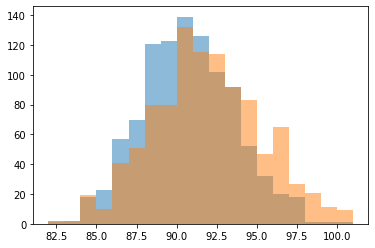

In [274]:
def plt_resc_hist(i):
    low = min(traj1contacts[:,i].min(),traj2contacts[:,i].min())
    hi = max(traj1contacts[:,i].max(),traj2contacts[:,i].max())+1

    plt.hist(traj1contacts[:,i],bins=range(low,hi),alpha=.5)
    plt.hist(traj2contacts[:,i],bins=range(low,hi),alpha=.5);
    
plt_resc_hist(75)

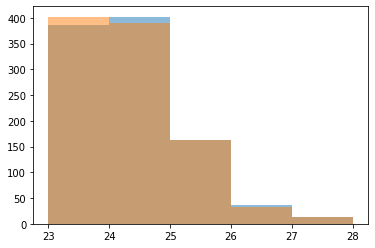

In [268]:
plt_resc_hist(80)

In [251]:
from scipy.stats import ks_2samp

In [275]:
help(ks_2samp)

Help on function ks_2samp in module scipy.stats.stats:

ks_2samp(data1, data2, alternative='two-sided', mode='auto')
    Compute the Kolmogorov-Smirnov statistic on 2 samples.
    
    This is a two-sided test for the null hypothesis that 2 independent samples
    are drawn from the same continuous distribution.  The
    alternative hypothesis can be either 'two-sided' (default), 'less'
    or 'greater'.
    
    Parameters
    ----------
    data1, data2 : sequence of 1-D ndarrays
        Two arrays of sample observations assumed to be drawn from a continuous
        distribution, sample sizes can be different.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the alternative hypothesis (see explanation above).
        Default is 'two-sided'.
    mode : {'auto', 'exact', 'asymp'}, optional
        Defines the method used for calculating the p-value.
        Default is 'auto'.
    
        - 'exact' : use approximation to exact distribution of test statistic


In [276]:
ks_2samp(traj1contacts[:,75],traj2contacts[:,75])

Ks_2sampResult(statistic=0.15, pvalue=3.143161402242108e-10)

In [277]:
ks_2samp(traj1contacts[:,80],traj2contacts[:,80])

Ks_2sampResult(statistic=0.015, pvalue=0.9998734489003387)

In [282]:
ks = []
for i in range(traj1contacts.shape[1]):
    ks.append(ks_2samp(traj1contacts[:,i],traj2contacts[:,i]))
ks = np.array(ks)

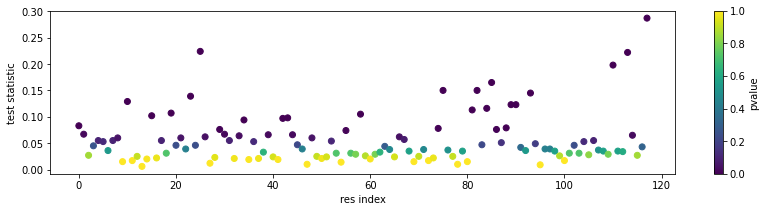

In [291]:
plt.figure(figsize=(14,3))
plt.scatter(range(len(ks)),ks[:,0],c=ks[:,1])
cbar = plt.colorbar()
cbar.set_label("pvalue")
plt.xlabel('res index')
plt.ylabel('test statistic');

# Water

Water is important.  Does the per-residue solvent accessibility change?  Let's count contacts with the explicit water molecules in the simulation.

In [342]:
def get_res_waters(traj,cutoff=2):
    '''Given an mdanalysis trajectory and contact distance cutoff, 
    count the number of water molecules within cutoff of each residue'''
    protein = traj.select_atoms('protein')
    resids = np.unique(protein.resids)
    ret = []
    for rid in resids:
        wat = traj.select_atoms('resname WAT and around %f resid %d'%(cutoff,rid))
        ret.append((rid,len(wat)))
    return pd.DataFrame(ret,columns=('resid','waters'))

In [347]:
get_res_waters(traj1)

,resid,waters
0,1,0
1,2,3
2,3,4
3,4,2
4,5,2
...,...,...
113,114,0
114,115,0
115,116,0
116,117,1


In [354]:
def traj1_frame_waters(i):
    traj1.trajectory[i]
    rc = get_res_waters(traj1)
    return rc.waters.to_numpy()

pool = multiprocessing.Pool()
traj1waters = pool.map(traj1_frame_waters,range(traj1.trajectory.n_frames))

In [355]:
def traj2_frame_waters(i):
    traj2.trajectory[i]
    rc = get_res_waters(traj2)
    return rc.waters.to_numpy()

pool = multiprocessing.Pool()
traj2waters = pool.map(traj2_frame_waters,range(traj2.trajectory.n_frames))

In [356]:
traj1waters = np.array(traj1waters)
traj2waters = np.array(traj2waters)

We can do the same sorts of analyses as with contacts:
 * compare means and compute Student's t-test between different samples (wt vs mutant)
 * compare distributions and compute Kolmogorov-Smirnov statistic

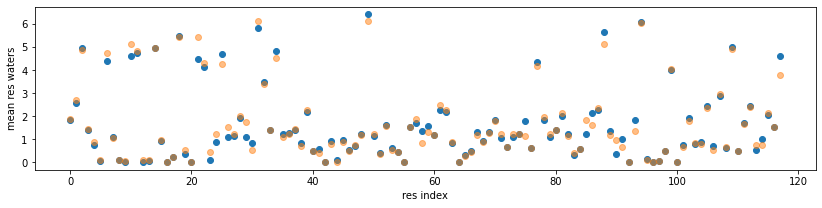

In [357]:
plt.figure(figsize=(14,3))
plt.plot(traj1waters.mean(axis=0),'o',label='traj1')
plt.plot(traj2waters.mean(axis=0),'o',label='traj2',alpha=.5)
plt.xlabel('res index')
plt.ylabel('mean res waters');

# Structure sanity check

In [363]:
traj1.add_TopologyAttr('tempfactors') 
protein = traj1.select_atoms('protein')
for residue, nwats in zip(protein.residues, traj1waters.mean(axis=0)):
    residue.atoms.tempfactors = nwats

In [368]:
protein.write('wt_wat.pdb')

In [381]:
import py3Dmol
v = py3Dmol.view()
v.addModel(open('wt_wat.pdb').read())
v.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient':'sinebow'}},
            'stick': {'colorscheme': {'prop':'b','gradient':'sinebow'}}})
v.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol